In [41]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [42]:
%pip install pydlm

You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [43]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [44]:
%pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [113]:
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
#import data
df = pd.read_csv('../Datasets/AMD Historical Data.csv')

#print data 
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,11.43,11.42,11.65,11.02,55.18M,0.79%
1,1/4/2017,11.43,11.45,11.52,11.23,40.78M,0.00%
2,1/5/2017,11.24,11.43,11.69,11.23,38.86M,-1.66%
3,1/6/2017,11.32,11.29,11.49,11.11,34.45M,0.71%
4,1/9/2017,11.49,11.37,11.64,11.31,37.30M,1.50%


In [47]:
#Bỏ dòng bị trống dự liệu
df = df.dropna()
#Chuyển đổi dữ liệu cột Vol. sang số
df['Vol.'] = df['Vol.'].str.replace('M', '').astype(float) * 1000000


In [48]:
#Chuyển đổi cột 'Change %' từ kiểu dữ liệu object sang kiểu dữ liệu float64
df['Change %'] = df['Change %'].str.rstrip('%').astype(float)


In [49]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,11.43,11.42,11.65,11.02,55180000.0,0.79
1,1/4/2017,11.43,11.45,11.52,11.23,40780000.0,0.00
2,1/5/2017,11.24,11.43,11.69,11.23,38860000.0,-1.66
3,1/6/2017,11.32,11.29,11.49,11.11,34450000.0,0.71
4,1/9/2017,11.49,11.37,11.64,11.31,37300000.0,1.50
...,...,...,...,...,...,...,...
1619,6/9/2023,124.92,123.57,127.25,123.55,75110000.0,3.20
1620,6/12/2023,129.19,128.52,130.48,126.40,85220000.0,3.42
1621,6/13/2023,124.53,132.32,132.83,122.45,131670000.0,-3.61
1622,6/14/2023,127.33,126.53,127.72,123.81,95240000.0,2.25


In [50]:
# Kiểm tra kiểu dữ liệu của cột 'Vol.'
print(df['Vol.'].dtype)

float64


In [51]:
print(df['Change %'].dtype)

float64


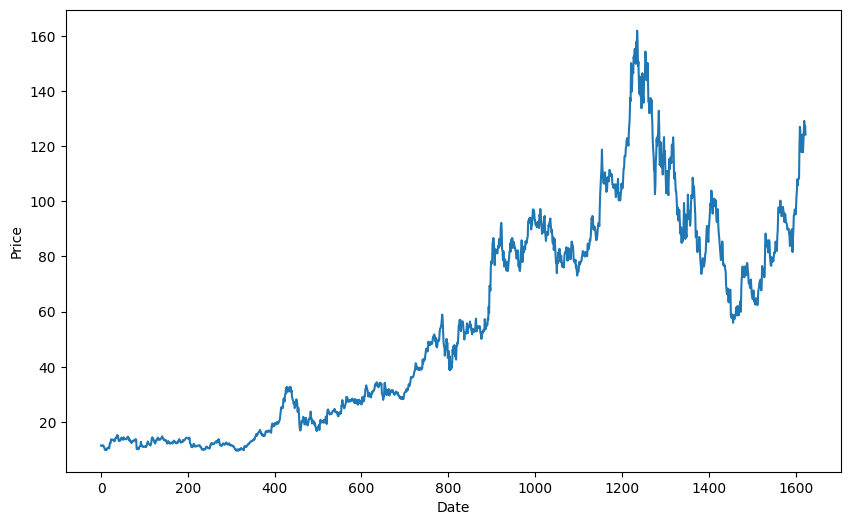

In [52]:
#Đảo ngược dữ liệu cho mô hình
# df = df[::-1]

figure=df['Price'].values
plt.figure(figsize=(10,6))
plt.plot(figure)
plt.xlabel('Date')
plt.ylabel('Price') 
plt.show()

In [53]:
#Xây dựng mô hỉnh với Bayesian Dynamic Linear Model
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason


In [54]:
df = df.reset_index(drop=True)
 # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [149]:
#Tính toán độ tương quan để biết cột nào có ảnh hưởng tới cột Price nhất
correlations = df.drop('Date', axis=1).corr()['Price']
most_influential_columns = correlations.drop('Price').nlargest(3).index.tolist()
most_influential_columns

['High', 'Low', 'Open']

In [151]:
from pydlm import dlm, trend, seasonality

# Tạo model DLM
my_dlm = dlm(train_data['Price'])

# Thêm trend component
# my_dlm = my_dlm + trend(degree=1, name='trend', w=1.0)

# Thêm seasonality component với chu kỳ 52 tuần
# my_dlm = my_dlm + seasonality(period=52, name='season', w=1.0)


#Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'Open' trong DataFrame
dynamic_features_Open = [[value] for value in df['Open'].values]
#Lấy đúng size theo train_data
train_dynamic_Open = dynamic_features_Open[:train_size]
my_dlm = my_dlm + dynamic(features=train_dynamic_Open, name='dynamicOpen', discount=0.95)

#Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'High' trong DataFrame
dynamic_features_High = [[value] for value in df['High'].values]
#Lấy đúng size theo train_data
train_dynamic_High = dynamic_features_High[:train_size]
my_dlm = my_dlm + dynamic(features=train_dynamic_High, name='dynamicHigh', discount=0.95)

#Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'Low' trong DataFrame
dynamic_features_Low = [[value] for value in df['Low'].values]
#Lấy đúng size theo train_data
train_dynamic_Low = dynamic_features_Low[:train_size]
my_dlm = my_dlm + dynamic(features=train_dynamic_Low, name='dynamicLow', discount=0.95)

# Thêm autoregressive component với độ lệch (degree) là 3
my_dlm = my_dlm + autoReg(degree=3, discount=0.99, name='ar3', w=1e7)
# #Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'Vol.' trong DataFrame
# dynamic_features_Vol = [[value] for value in df['Vol.'].values]
# #Lấy đúng size theo train_data
# train_dynamic_Vol = dynamic_features_Vol[:train_size]
# my_dlm = my_dlm + dynamic(features=train_dynamic_Vol, name='dynamicVol', discount=0.95)

# #Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'Change' trong DataFrame
# dynamic_features_Change = [[value] for value in df['Change %'].values]
# #Lấy đúng size theo train_data
# train_dynamic_Change = dynamic_features_Change[:train_size]
# my_dlm = my_dlm + dynamic(features=train_dynamic_Change, name='dynamicChange', discount=0.95)


# #Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'High' trong DataFrame
# dynamic_features_Price = [[value] for value in df['Price'].values]
# #Lấy đúng size theo train_data
# train_dynamic_Price = dynamic_features_Price[:train_size]
# my_dlm = my_dlm + dynamic(features=train_dynamic_Price, name='dynamicPrice', discount=0.95)


In [152]:

# Fit the DLM to the training data
my_dlm.fit()


Initializing models...
Initialization finished.
Starting forward filtering...


Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [156]:
# Tạo featureDict cho dự đoán
featureDict = {
    'dynamicOpen': train_dynamic_Open,
    'dynamicHigh': train_dynamic_High,
    'dynamicLow': train_dynamic_Low,
    # 'dynamicVol': train_dynamic_Vol,
    # 'dynamicChange': train_dynamic_Change
}

# featureDict = {
#     'dynamicPrice': train_dynamic_Price,
# }

In [157]:
# print(len(train_dynamic_Change))
# print(len(featureDict['dynamicOpen']))


In [158]:
# Predict on validation set
prediction = my_dlm.predictN(N=30, featureDict=featureDict)

In [159]:
# Predict on validation data
val_preds, val_vars = my_dlm.predictN(N=val_size, featureDict=featureDict)

# Predict on test data
test_preds, test_vars = my_dlm.predictN(N=test_size, featureDict=featureDict)
# Predict on train data
train_preds, train_vars = my_dlm.predictN(N=train_size, featureDict=featureDict)

In [160]:
# Các giá trị thực tế cho validation, test và train data
val_actual = val_data['Price'].values
test_actual = test_data['Price'].values
train_actual = train_data['Price'].values

In [161]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

# Regression metrics
test_rmse = np.sqrt(np.mean((test_preds - test_actual)**2))
test_mse = mean_squared_error(test_actual, test_preds)
test_mae = mean_absolute_error(test_actual, test_preds)

valid_rmse = np.sqrt(np.mean((val_preds - val_actual)**2))
valid_mse = mean_squared_error(val_actual, val_preds)
valid_mae = mean_absolute_error(val_actual, val_preds)

print('Testing RMSE:', test_rmse)
print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)

print('Validation RMSE:', valid_rmse)
print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)

Testing RMSE: 96.03052321987313
Testing MSE: 9221.861389882592
Testing MAE: 93.07980579408392
Validation RMSE: 73.3069063184093
Validation MSE: 5373.902513976038
Validation MAE: 70.31463554316514


In [162]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

In [163]:
# Dự đoán 30 ngày tiếp theo sau tập validation
future_preds, future_vars = my_dlm.predictN(N=30, featureDict=featureDict)

# In ra dự đoán cho 30 ngày tiếp theo
print("Predictions for the next 30 days:")
print(future_preds)

Predictions for the next 30 days:
[60.01278588100203, 57.15719615922476, 48.371650490082594, 39.06671951992937, 35.37869312020569, 30.160683826004767, 26.26163805690204, 23.33383521994695, 20.712539094110713, 18.421852773973903, 16.723729219926486, 15.351548381717619, 14.098189689565729, 13.236053987850507, 12.601675774250868, 12.054801166155277, 11.626018542130108, 11.319472022439824, 10.964047504026814, 10.722525095214143, 10.982525390954192, 11.113133639380193, 11.067433856755532, 11.526894275942096, 11.68510672557195, 11.799536772879163, 12.018333823044618, 12.049742478495382, 12.218253568984732, 12.172326869144333]


In [164]:
#Tạo một mảng chứa toàn bộ dữ liệu của tập train, validation và test
allPreds = np.concatenate([train_preds,test_preds, val_preds])


In [165]:
#Tạo mảng index tương ứng với tập allPreds
days = np.arange(0, len(allPreds))


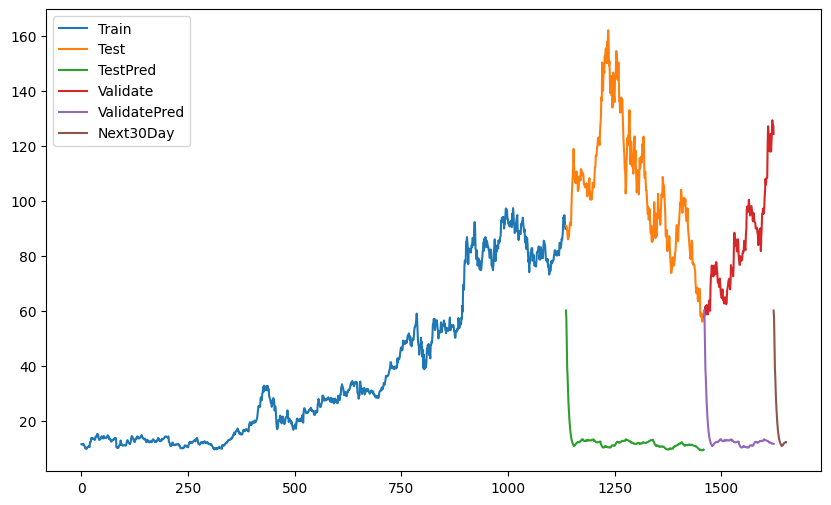

In [166]:
#Vẽ hình
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(days[len(train_data.index):len(train_data.index)+len(test_preds)], test_preds, label='Prediction')
plt.plot(val_data.index, val_data['Price'])
plt.plot(days[len(train_data.index)+len(test_preds):], val_preds, label='Validate')
plt.plot(last_data,future_preds, label='Next30Day')

#plt.plot(pred_df.index, pred_df['Price'], label='Predicted')
plt.legend(['Train', 'Test', 'TestPred', 'Validate', 'ValidatePred', 'Next30Day'])
plt.show()